# PDF estimation using histogram-based and kernel density estimation (KDE) methods.

Given a dataset, we can estimate its probability distribution function (PDF) using a method based on histograms. 
However, this straightforward and popular approach is often hampered by the choice of parameters. Hence, small changes on 
the histogram boundaries $[x_{min}, x_{max}]$ and the number of bins used can modify substantially the shape 
of the estimated PDF. The resulting PDF is also a step function where derivatives are zero or are not defined.

A solution is to use KDE methods which generally require a single parameter, the kernel bandwidth. They are 
also very useful when we need to estimate the smooth PDF of a signal for which we have no theoretical model. 
KDE methods are nonparametric and perform well in many situations.

## Reference probability distribution function

In this script we use a composite PDF that is the sum of a gaussian and an exponential PDF:
    
<blockquote> $P(x) = \alpha N(x|\mu, \sigma) + (1-\alpha) Exp(x|\lambda)$ </blockquote>

More specifically, we use the following PDF model:

<blockquote> $P(x) = 0.7 N(x|30, 2) + 0.3 Exp(x|5)$ </blockquote>

This is the reference PDF against which other PDF from several estimation methods are compared to.

N.B. We use 1-D datasets in this script; N-D datasets can be handled using similar metods extended to higher dimensions.  

In [1]:
print(__doc__)

# Authors: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: XXX

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import math
from scipy.stats import expon, norm
import seaborn as sns; sns.set()

# For replicability
np.random.seed(42)

Automatically created module for IPython interactive environment


# Part I: Dataset generation
In this section, we generate a dataset and compute an approximate histogram-based PDF from it. 
The goal is to compare both empirical and analytical PDF.

Let us first define the dataset generation function:

In [2]:
def generate_dataset(npts, prob_PDF, coeffs):
    # Number of data points in each distributon
    n = (npts*prob_PDF).astype(int)

    # Exponential component
    lam = coeffs[0]
    X1 = np.random.exponential(lam, size=n[0])

    # Gaussian component
    mu = coeffs[1]
    sigma = coeffs[2]
    X2 = np.random.normal(mu, sigma, size=n[1])
    
    X = np.r_[X1, X2]
    
    return X


Let us generate a dataset of 100K points and compare the PDF model with the approximate histogram-based PDF .

In [3]:
# Parameters of the reference PDF 
# Exponential
lam = 5.

# Gaussian 
mu = 30.
sigma = 2.

coeffs = np.array([lam, mu, sigma]) 

# A priori probabilities of the two PDF components
prob_PDF = np.array([.7, .3])


In [4]:
# Dataset generation
npts = 100000
X = generate_dataset(npts, prob_PDF, coeffs)

Compare the histogram-based PDF with the PDF model. The 'experimental' PDF agrees quite well with the 'theoretical' model.

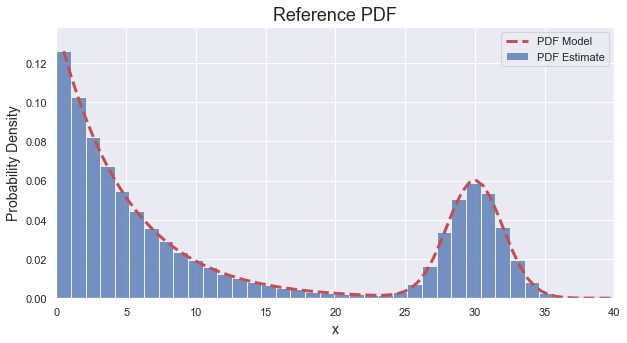

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

nbins = 50
hist,edges, patches = plt.hist(X, nbins, density=True, facecolor='b', alpha=0.75, label='PDF Estimate')

h = edges[1] - edges[0]
x = edges[:-1]+h/2.

xx = np.linspace(x.min(), x.max(), 100)
model = prob_PDF[0]*expon.pdf(xx, 0., lam) + prob_PDF[1]*norm.pdf(xx, mu, sigma) 

plt.plot(xx, model, ls="--", color='r', linewidth=3, label='PDF Model')

ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('Probability Density', fontsize=14)
ax.set_title('Reference PDF', fontsize=18)
ax.legend(loc='upper right')

x_min = 0
x_max = 40
y_min = 0
y_max = 1.1*model.max()
ax.set_xlim([x_min, x_max]);
ax.set_ylim([y_min, y_max]);

plt.savefig('1D_PDF_estimation_1.png', format="png")

# Part II: Compare various PDF-estimation methods

## Standard histogram-based PDF
The probability density $\hat P(x)$ is proportional to the number of data points $x^{t}$ inside the h-width bin centered at $x$

<blockquote>  $\hat P(x) = \frac{\# \{x^{t}\}}{Nh}$ </blockquote>

The shape of the histogram depends on several parameters such as the histogram boundaries $[x_{min}, x_{max}]$ 
and the number of bins used. The example above used nbins=50.

The next figure shows how the bin width <i>h</i> affects the PDF shape. The effect is particularly striking when the number 
of data points is small (npts=20). As a reference, the PDF model is overlaid on the experimental PDF in the last panel of 
the series.

Large <i>h</i> values produce a smooth PDF whereas small <i>h</i> values create a spiky look where each data point
has a strong impact on the local PDF value. 

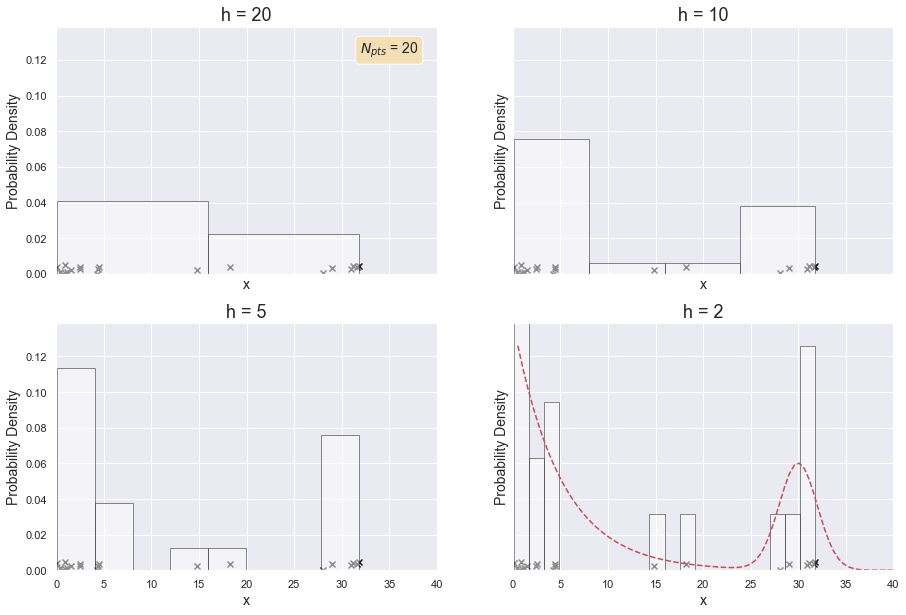

In [6]:
npts = 20
X = generate_dataset(npts, prob_PDF, coeffs)

# Used to print the data points along the x axis
y0 = 0.005 * np.random.random(X.shape)

width = x_max - x_min
fig, axs = plt.subplots(2, 2, figsize = (15,10), sharex=True, sharey=True) 

# Several values of nbins are used
for k,nbins in enumerate([2, 4, 8, 20]):
    i = k // 2
    j = k % 2
    hist,edges, patches = axs[i,j].hist(X, nbins, density=True, facecolor='w', edgecolor='k', alpha=0.5)
    axs[i,j].scatter(X, y0, marker='x', color='k')

    if (i==0 and j==0):
        text = r'$N_{pts}$' + ' = %d' % (npts)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
        axs[i,j].text(35, 0.12, text, fontsize=14, horizontalalignment='center',  verticalalignment='bottom', bbox=props)
        
        
    if (k==3):
        # Overlay PDF model
        axs[i,j].plot(xx, model, ls="--", color="r")
        
    axs[i,j].set_xlabel('x', fontsize=14)
    axs[i,j].set_ylabel('Probability Density', fontsize=14)
    axs[i,j].set_title('h = %d' % (width/nbins), fontsize=18)
    axs[i,j].set_xlim([x_min, x_max]);
    axs[i,j].set_ylim([y_min, y_max]);
    
plt.savefig('1D_PDF_estimation_2.png', format="png")

## Naive PDF estimator
The probability density $\hat P(x)$ is proportional to the number of data points $x^{t}$ inside the interval $[x-h, x+h[$ 

<blockquote>  $\hat P(x) = \frac{\# \{(x-h)<x^{t}\le x+h\}}{2Nh} = \frac{1}{2Nh}\sum_{t=1}^{N} W(\frac{x-x^{t}}{h})$ </blockquote> 
                                 
with the Top Hat (or Boxcar) kernel

<blockquote>  $W(u) =     
    \begin{cases}
      1, & \text{if} |u| < 1 \\
      0, & \text{otherwise}
    \end{cases}$
</blockquote> 
                                 

Let us look at the effect of the width <i>h</i> on the shape of the PDF. Once again, large values of <i>h</i> smooth 
out the PDF whereas small values of <i>h</i> create a spiky appearance.  

In [7]:
def naive_estimator(xx, X, h):
    N = X.shape[0]
    cte = 1./(2*N*h)
    p = np.zeros(xx.shape[0])
    for i,x in enumerate(xx):
        u = (x-X)/h
        p[i] = cte * np.sum(np.abs(u)<1)
    
    return p
    

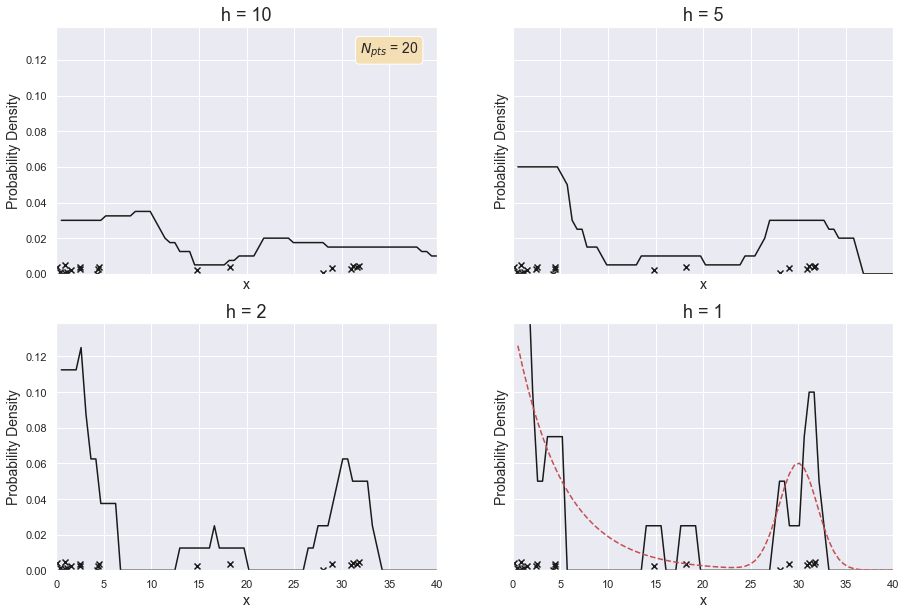

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (15,10), sharex=True, sharey=True) 

for k,nbins in enumerate([4, 8, 20, 40]):
    i = k // 2
    j = k % 2
    
    h = width/nbins
    pdf = naive_estimator(xx, X, h)
    axs[i,j].plot(xx, pdf, ls='-', color='k')
    axs[i,j].scatter(X, y0, marker='x', color='k')

    if (i==0 and j==0):
        text = r'$N_{pts}$' + ' = %d' % (npts)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
        axs[i,j].text(35, 0.12, text, fontsize=14, horizontalalignment='center',  verticalalignment='bottom', bbox=props)

    if (k==3):
        axs[i,j].plot(xx, model, ls="--", color="r")
        
    axs[i,j].set_xlabel('x', fontsize=14)
    axs[i,j].set_ylabel('Probability Density', fontsize=14)
    axs[i,j].set_title('h = %d' % (width/nbins), fontsize=18)
    axs[i,j].set_xlim([x_min, x_max]);
    axs[i,j].set_ylim([y_min, y_max]);
    
plt.savefig('1D_PDF_estimation_3.png', format="png")

## PDF with kernel methods
The probability density $\hat P(x)$ can be modeled as the convolution of the data distribution with a kernel $K(u)$ designed to
smooth the experimental PDF

<blockquote>  $\hat P(x) = \frac{1}{Nh}\sum_{t=1}^{N} K(\frac{x-x^{t}}{h})$ </blockquote> 
                                 
The level of smoothing is controled by the bandwidth parameter <i>h</i>. 
<br><br>    


Several types of kernels are particularly useful:
    
<blockquote>  Gaussian: $K(u)= \frac{1}{\sqrt{2\pi}} \exp [-\frac{u^{2}}{2}]$ </blockquote>

<blockquote>  Top-Hat/Boxcar: $K(u)= \frac{1}{2}$ for $u \in [-1, 1]$ </blockquote>
    
<blockquote>  Epanechikov: $K(u)= \frac{3}{4}(1-u^{2})$ for $u \in [-1, 1]$ </blockquote>
    
<blockquote>  Biweight: $K(u)= \frac{15}{16}(1-u^{2})^{2}$ for $u \in [-1, 1]$ </blockquote>

<blockquote>  TriCube: $K(u)= \frac{70}{81}(1-|u|^{3})^{3}$ for $u \in [-1, 1]$ </blockquote>

<blockquote>  Triangular: $K(u)= (1-|u|)$ for $u \in [-1, 1]$ </blockquote>
  
N.B. The most popular kernel is the gaussian one. It is also the only one in the list that goes beyond the interval $[-1, 1]$
<br><br>

Let us look at them.     

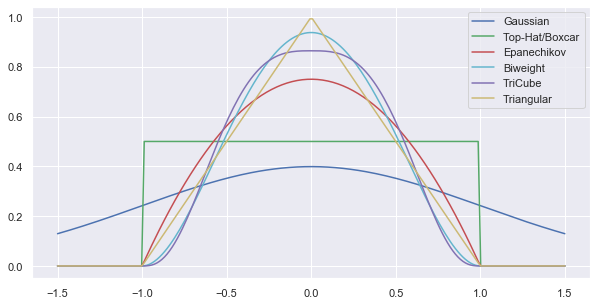

In [9]:
u = np.linspace(-1.5, 1.5, 200)
v = np.abs(u) 
t = v<1

y = np.zeros((6,u.shape[0]))
y[0,:] = np.exp(-u**2/2)/np.sqrt(2*np.pi)
y[1,:] = 0.5*t
y[2,:] = (3/4)*(1-v**2)
y[3,:] = (15/16)*(1-v**2)**2
y[4,:] = (70/81)*(1-v**3)**3
y[5,:] = (1-v)

indx = np.where(v>=1)
for k in range(1,6):
    y[k,indx] = 0
    
colors = np.array([c for c in 'bgrcmyk'])
labels = ['Gaussian', 'Top-Hat/Boxcar', 'Epanechikov', 'Biweight', 'TriCube', 'Triangular']

fig, ax = plt.subplots(1,1,figsize=(10,5))

for k in range(6):
    ax.plot(u, y[k,:], ls='-', color=colors[k], label=labels[k])

ax.legend(loc='upper right')

plt.savefig('1D_PDF_estimation_4.png', format="png")

The following series of panels shows the effect of using a $\bf{gaussian}$ kernel with a varying bandwidth <i>h</i>. 
The KDE method produces results smoother than the naive histogram one. 

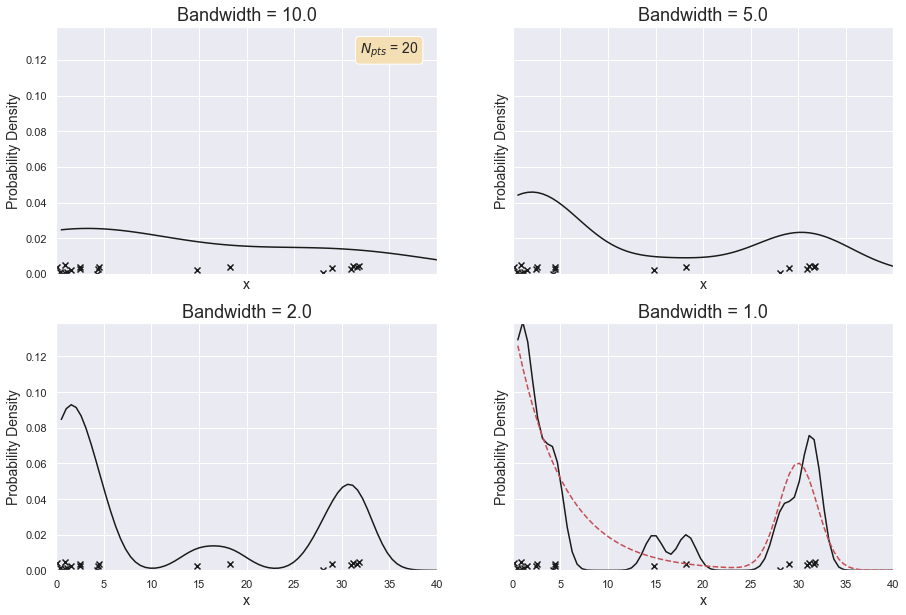

In [10]:
from sklearn.neighbors import KernelDensity


fig, axs = plt.subplots(2, 2, figsize = (15,10), sharex=True, sharey=True) 

for k,bandwidth in enumerate([10, 5, 2, 1]):
    i = k // 2
    j = k % 2

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X.reshape(-1,1))
    pdf = np.exp( kde.score_samples(xx.reshape(-1,1)))

    axs[i,j].plot(xx, pdf, ls='-', color='k')
    axs[i,j].scatter(X, y0, marker='x', color='k')


    if (k==0):
        text = r'$N_{pts}$' + ' = %d' % (npts)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
        axs[i,j].text(35, 0.12, text, fontsize=14, horizontalalignment='center',  verticalalignment='bottom', bbox=props)
    
    if (k==3):
        axs[i,j].plot(xx, model, ls="--", color="r")
    
    axs[i,j].set_xlabel('x', fontsize=14)
    axs[i,j].set_ylabel('Probability Density', fontsize=14)
    axs[i,j].set_title('Bandwidth = %.1f' % bandwidth, fontsize=18)
    axs[i,j].set_xlim([x_min, x_max])
    axs[i,j].set_ylim([y_min, y_max])

plt.savefig('1D_PDF_estimation_5.png', format="png")


What is the effect of increasing the number of data points?

The following series of panels shows the effect of using a $\bf{gaussian}$ kernel with varying bandwidth 
and number of data points. Increasing the number of data points improves the quality of the estimated PDF.
This should not be surprising as more information is available. This is true for all bandwith values shown.

As more data points become available, we should reduce the bandwith value. The best bandwiths-Npts combinations seem to appear 
along the main diagonal of the figure.


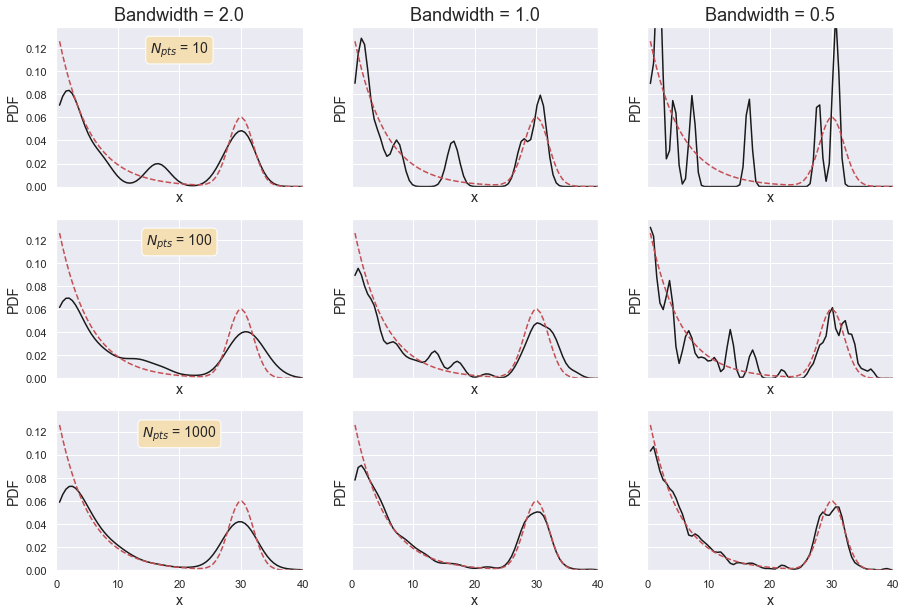

In [11]:
from sklearn.neighbors import KernelDensity


fig, axs = plt.subplots(3, 3, figsize = (15,10), sharex=True, sharey=True) 

for i,npts in enumerate([10, 100, 1000]):
    X = generate_dataset(npts, prob_PDF, coeffs)
    for j,bandwidth in enumerate([2, 1., 0.5]):


        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X.reshape(-1,1))
        pdf = np.exp( kde.score_samples(xx.reshape(-1,1)))

        axs[i,j].plot(xx, pdf, ls='-', color='k')

        if (k==3):
            axs[i,j].plot(xx, model, ls="--", color="r")

        axs[i,j].set_xlabel('x', fontsize=14)
        axs[i,j].set_ylabel('PDF', fontsize=14)
        if (i==0):
            axs[i,j].set_title('Bandwidth = %.1f' % bandwidth, fontsize=18)
        
        if (j==0):
            text = r'$N_{pts}$' + ' = %d' % (npts)
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
            axs[i,j].text(20, 0.11, text, fontsize=14, horizontalalignment='center',  verticalalignment='bottom', bbox=props)
        
        axs[i,j].set_xlim([x_min, x_max]);
        axs[i,j].set_ylim([y_min, y_max]);

plt.savefig('1D_PDF_estimation_6.png', format="png")


Let us compare the KDE smoothing performance with several kernels. First we define the displaying function.

In [12]:
from sklearn.neighbors import KernelDensity

def compare_kernels(npts, prob_PDF, coeffs, bandwidth, figName):
    X = generate_dataset(npts, prob_PDF, coeffs)

    kernels = ['gaussian', 'tophat', 'epanechnikov','linear','cosine']
    kernel_names = ['Gaussian', 'TopHat', 'Epanechnikov','Linear','Cosine']
    
    fig, axs = plt.subplots(3, 2, figsize = (15,15), sharex=True, sharey=True) 

    for k, kernel in enumerate(kernels):
        i = k // 2
        j = k % 2

        kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X.reshape(-1,1))
        pdf = np.exp( kde.score_samples(xx.reshape(-1,1)))

        axs[i,j].plot(xx, pdf, ls='-', color='k')
        axs[i,j].plot(xx, model, ls="--", color="r")

        axs[i,j].set_xlabel('x', fontsize=14)
        axs[i,j].set_ylabel('PDF', fontsize=14)

        axs[i,j].set_title(kernel_names[k], fontsize=18)

        if (k==0):
            text1 = r'$N_{pts}$' + ' = %d' % (npts)
            text2 = 'Bandwidth = %.1f' % (bandwidth)
            text = text1 +'\n' + text2
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
            axs[i,j].text(39, 0.1, text, fontsize=14, horizontalalignment='right',  verticalalignment='bottom', bbox=props)

        axs[i,j].set_xlim([x_min, x_max]);
        axs[i,j].set_ylim([y_min, y_max]);

    axs[2,1].set_axis_off()

    plt.savefig(figName, format="png")

The next figure shows the smoothing performances of each kernel for a dataset of 200 points and a bandwidth of $h=1$. 
The narrower exponential PDF component is well reproduced; finer details require smaller bandwidths.

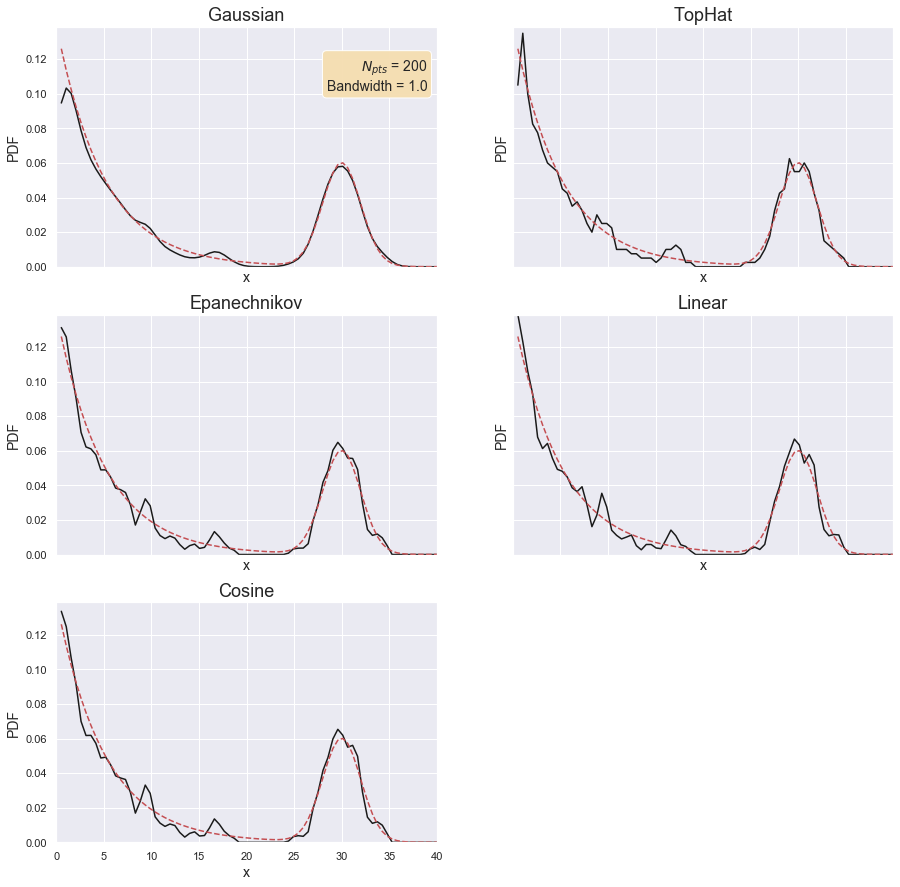

In [13]:
bandwidth = 1.
npts = 200
figName = '1D_PDF_estimation_7.png'

compare_kernels(npts, prob_PDF, coeffs, bandwidth, figName)

The next figure shows, this time around, the smoothing performances with a bandwidth of $h=2$. The smoother gaussian 
PDF component is well reproduced; larger details are better revealed using larger bandwidths.

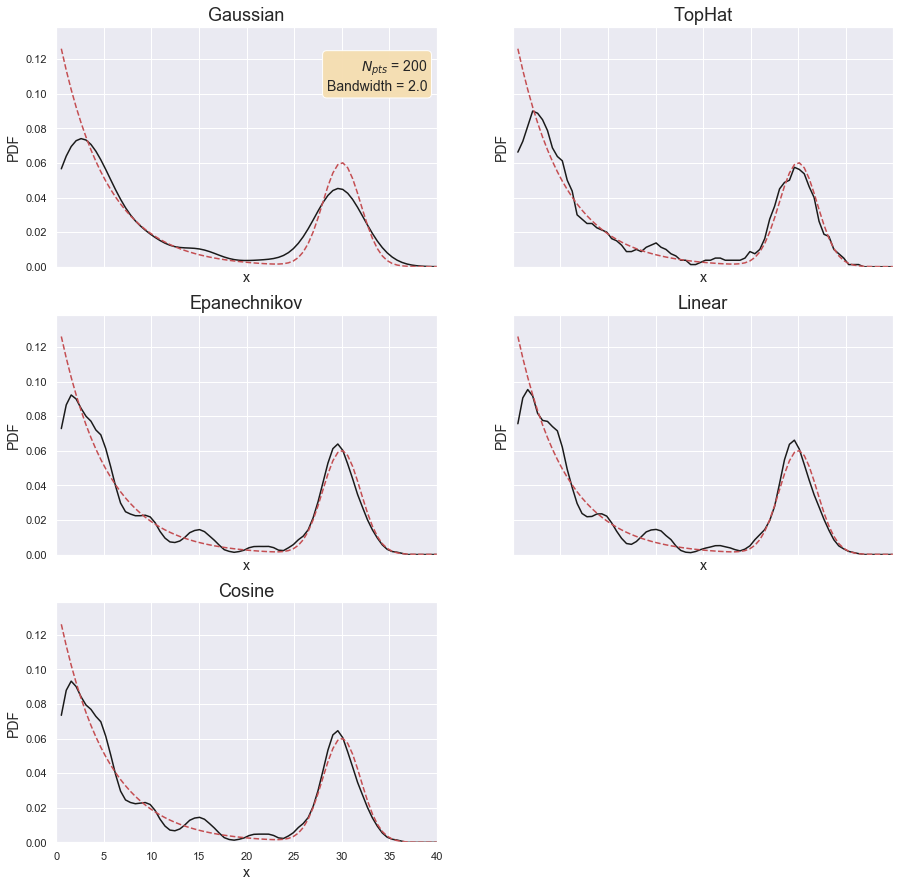

In [14]:
bandwidth = 2.
npts = 200
figName = '1D_PDF_estimation_8.png'

compare_kernels(npts, prob_PDF, coeffs, bandwidth, figName)

## How do standard histogram and KDE methods compare?

The next figure shows the standard histogram results with those from the KDE with the $\bf{Epanechnikov}$ kernel 
and a bandwidth of $h=2$. The KDE results look better; more accurate and less noisy. 

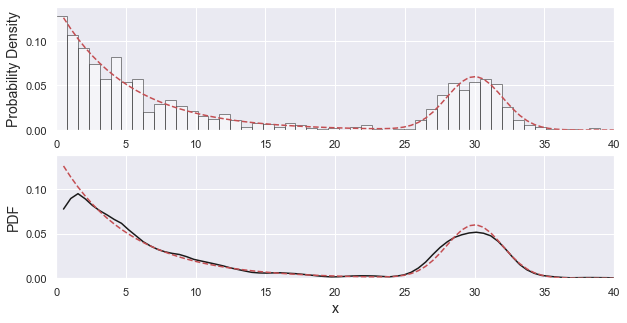

In [15]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize = (10,5)) 


# Histogram-based method
ax1.hist(X, 50, density=True, facecolor='w', edgecolor='k', alpha=0.5)
ax1.plot(xx, model, ls="--", color='r')
ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('Probability Density', fontsize=14)
ax1.set_xlim([x_min, x_max])
ax1.set_ylim([y_min, y_max])

# Kernel-based method
kde = KernelDensity(kernel='epanechnikov', bandwidth=2.).fit(X.reshape(-1,1))
pdf = np.exp( kde.score_samples(xx.reshape(-1,1)))

ax2.plot(xx, pdf, ls='-', color='k')
ax2.plot(xx, model, ls="--", color="r")
ax2.set_xlabel('x', fontsize=14)
ax2.set_ylabel('PDF', fontsize=14)
ax2.set_xlim([x_min, x_max]);
ax2.set_ylim([y_min, y_max]);

plt.savefig('1D_PDF_estimation_9.png', format="png")